# Mortgage Loan Lifecycle Evaluation

In the mortgage industry, financial institutions face significant challenges in managing and evaluating mortgage loans, from origination to repayment or default. These challenges include accurately predicting loan defaults, assessing borrower risk, optimizing loan approval processes, and managing the financial impact of loans on institutional balance sheets. Inconsistent loan evaluation can result in increased default rates, financial losses, and non-compliance with regulatory standards.

The objective of this project is to analyze mortgage loans and build predictive models to assist financial institutions in managing loans more efficiently. The project aims to:

1. Predict loan outcomes (approval, denial, default risk) using machine learning techniques.
2. Analyze critical loan features (e.g., loan type, balance, FICO score, LTV) to identify factors influencing loan performance.
3. Visualize loan data trends to help institutions optimize their lending strategies.
4. Provide what-if scenarios for financial officers to assess the impact of different financial and borrower conditions on loan portfolios.

Loan file template requires below details: 
- Loan ID: to identify the special loan 
- Loan Type: to indicate the loan if fixed rate, or balloon loan , or ARM, or AMP (alternative mortgage product).
- Balance: 
- Loan program type: to indicate conforming loan, FHA/VA loan, Jumbo loan or sub-prime loan 
- Current coupon rate: 
- Amortization type: the original amortization term 
- Maturity: the maturity loan (the remaining term of the loan) 
- FICO Score: the updated fico score 
- LTV: the current loan to value ratio 
- Loan Size: the loan amount of the loan 
- Loan origination location (City & Zip) 
- Unit Types (Types of property)

### Importing Libraries

In [2]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os                             
import pandas as pd                   
import matplotlib.pyplot as plt       
import seaborn as sns
import numpy as np                    
from IPython.display import display  
import scipy.stats as stats
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew

### Loading file

In [3]:
data = pd.read_csv('mwb2014.csv', header=0, encoding='cp1252')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   First Name              2501 non-null   object 
 1   Last Name               2501 non-null   object 
 2   City                    2501 non-null   object 
 3   State                   2501 non-null   object 
 4   Zip                     2501 non-null   int64  
 5   Loan Amount             2501 non-null   float64
 6   Estimated Value         2501 non-null   int64  
 7   Loan Purpose            2501 non-null   object 
 8   Qualification FICO      2501 non-null   int64  
 9   Is Primary Wage Earner  2501 non-null   bool   
 10  Income Type             2501 non-null   object 
 11  Asset Docs              2501 non-null   object 
 12  Occupancy               1846 non-null   object 
 13  Unit Type               2501 non-null   object 
 14  Loan Type               2501 non-null   

In [4]:
data.shape

(2501, 24)

In [5]:
numeric_data = data.select_dtypes(include='number')
percentiles = numeric_data.quantile([0.05, 0.95])
print(percentiles)

          Zip  Loan Amount  Estimated Value  Qualification FICO  CLTV  \
0.05   7083.0     150000.0         205275.0               636.0   0.0   
0.95  11756.0     840000.0        1400000.0               803.0  96.0   

      LoanInMonth  
0.05          3.0  
0.95         56.0  


In [6]:
St=['CT', 'FL', 'NJ', 'NY', 'PA']
print(St)

['CT', 'FL', 'NJ', 'NY', 'PA']


### Creating dataframe subsets by state

In [7]:
ct_data = data[data['State'].isin(['CT'])]
fl_data = data[data['State'].isin(['FL'])]
ny_data = data[data['State'].isin(['NY'])]
nj_data = data[data['State'].isin(['NJ'])]
pa_data = data[data['State'].isin(['PA'])]

### Filtering out columns

In [8]:
filtered_columns =('Created Date', 'First Name', 'Last Name', 'Loan Amount', 'City', 'unit_type_code', 'Loan Type')
ct_lo_amount = ct_data.reindex(columns=filtered_columns)
fl_lo_amount = fl_data.reindex(columns=filtered_columns)
nj_lo_amount = nj_data.reindex(columns=filtered_columns)
ny_lo_amount = ny_data.reindex(columns=filtered_columns)
pa_lo_amount = pa_data.reindex(columns=filtered_columns)

### Distribution of index of accessbility of Loan Amount

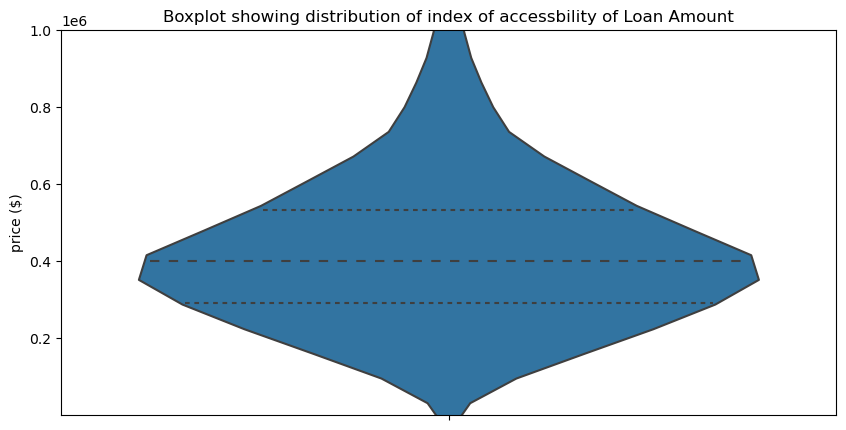

In [9]:
plt.figure(figsize=(10,5))
sns.violinplot(y=data['Loan Amount'],inner="quartile")
plt.title("Boxplot showing distribution of index of accessbility of Loan Amount")
plt.ylim(0.1,1000000)
plt.ylabel('price ($)')
plt.show()

### We can see that mid 50% loan amount between USD 340,000 & USD 570,000

## Mortgage interest rates

Mortgage interest rates have a significant impact on the amount of mortgage applications. If the interest rates are low, the mortgages are relatively cheaper for the borrower as they have to pay less interest, which leads to an increased amount of mortgage applications. A high mortgage interest rate means the mortgage borrower pays a high amount of interest to the lender, which makes the mortgage less attractive for the borrower. Interest rate changes have a significant impact on mortgage applications, as was seen in November of last year, where a sudden increase in interest rates led to a large peak in mortgage applications. The main difference between the mortgages offered by these types of companies lies in the mortgage interest rates. Even a small difference in mortgage interest rates can often save or cost the borrower a vast amount of money, due to the large sum of a mortgage.

In general, there are two types of mortgage interest rate: variable rates (ARM) and fixed rates. Variable interest rates are generally lower than fixed interest rates, but can change every month. Fixed interest rates are slightly higher, but are fixed for a certain period of time. A fixed interest rate is generally preferred when the mortgage interest rates are expected to rise, or when the borrower wants to know its monthly expenses upfront. A variable interest rate (ARM) is preferred when interest rates are expected to decrease. If a financial institution has a significantly higher interest rate than its competitors, it will generally receive fewer mortgage applications as the independent mortgage advisors will forward its customers to a different mortgage lender.

Financial institutions sometimes increase their interest rates during the summer months, and at the end of the year, as there is less personnel available to handle the requests due to vacations and holidays. With less personnel available they can handle less mortgage requests, so in order to keep the processing time the same they choose to reduce the input, by increasing the interest rates. Financial institutions may also specifically keep interest rates low for mortgages with a certain fixed interest period. Interest rate changes are not always directly influenced by changes in the cost of lending, but can have numerous reasons.


### Load US 10-Years Treasury Data

In [10]:
US10Y = pd.read_csv('US10Y.csv', header=0, index_col='DATE', encoding='cp1252')
US10Y.head()

,RATE
DATE,
10/14/2014,2.21
10/15/2014,2.15
10/16/2014,2.17
10/17/2014,2.22
10/20/2014,2.2


In [12]:
US10Y.replace(".", value=np.nan, inplace=True)
US10Y= US10Y.replace(to_replace=-1, value=np.nan)
US10Y.RATE.value_counts()

RATE
2.33    21
2.27    20
2.24    19
2.32    19
2.36    18
        ..
2.58     1
2.72     1
2.7      1
2.65     1
3.24     1
Name: count, Length: 168, dtype: int64

In [13]:
US10Y= US10Y.fillna(method='ffill')
US10Y= US10Y[['RATE']].astype('float64')
US10Y.info()
US10Y.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1098 entries, 10/14/2014 to 12/27/2018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    1098 non-null   float64
dtypes: float64(1)
memory usage: 17.2+ KB


,RATE
count,1098.000000
mean,2.302286
std,0.423337
min,1.370000
25%,2.030000
50%,2.270000
75%,2.507500
max,3.240000


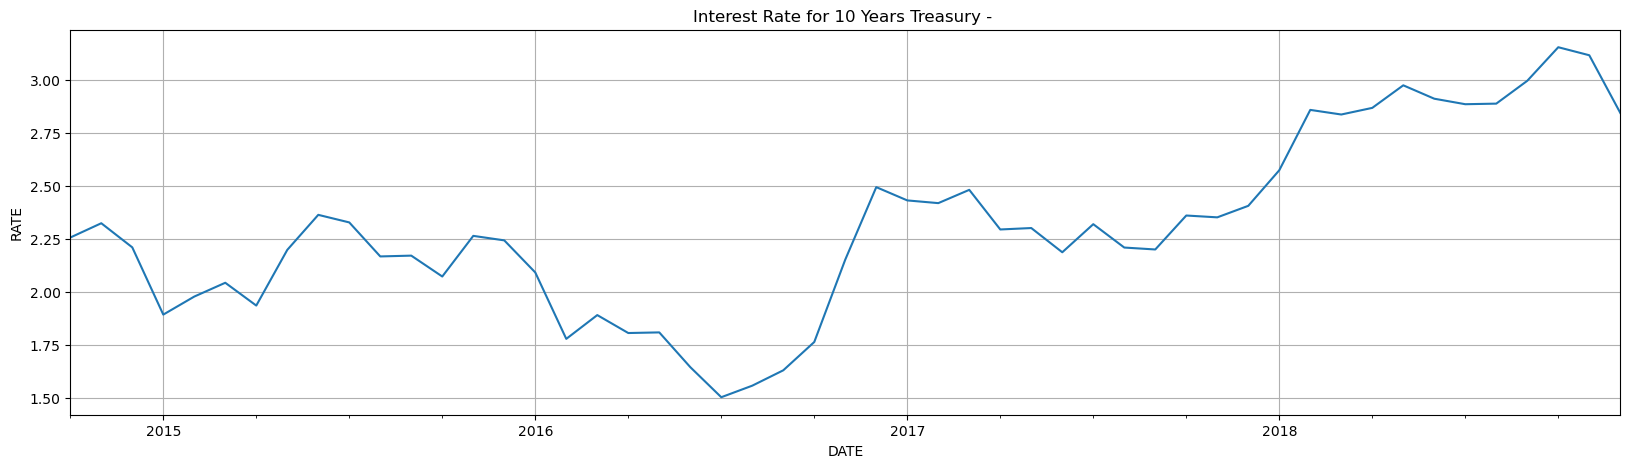

In [14]:
US10Y.index = pd.to_datetime(US10Y.index)
ax=monthly_rate_data=US10Y.resample('M').mean().plot(title="Interest Rate for 10 Years Treasury - ",figsize=(20,5))
plt.ylabel('RATE')
ax.get_legend().remove()
plt.grid()

### Display Monthly US Treasury 10 Years Interest Rate

Generally, when US 10 Years Treasury Rate fluctuates, that leads lenders to adjust their internal bank rates accordingly. Also interest rates for consumers varies on several risk factors, such as DTI (Debt to Income Ratio), FICO Scores, Recent derogatory events on their credit history, stable job history, W2 or 1099, Stated Income, Profit or Loss Statements, Student Loans, Auto Payments, Credit utilization, Property types, number of households, rental history, etc.
Interest Rate is currently historical low. In the short run rate may go ups and down but in the long run rate will go up. As housing price goes up, interest rate will go up to control the housing price.

In [16]:
loan_patterns = data[['Loan Amount', 'Created Date']]
loan_patterns.head()

,Loan Amount,Created Date
0,506250.0,10/14/2014
1,206250.0,10/14/2014
2,648700.0,10/14/2014
3,412750.0,10/14/2014
4,522588.0,10/14/2014


Text(0.5, 1.0, 'Histogram with fitted normal distribution for Mortgage Bank Loan')

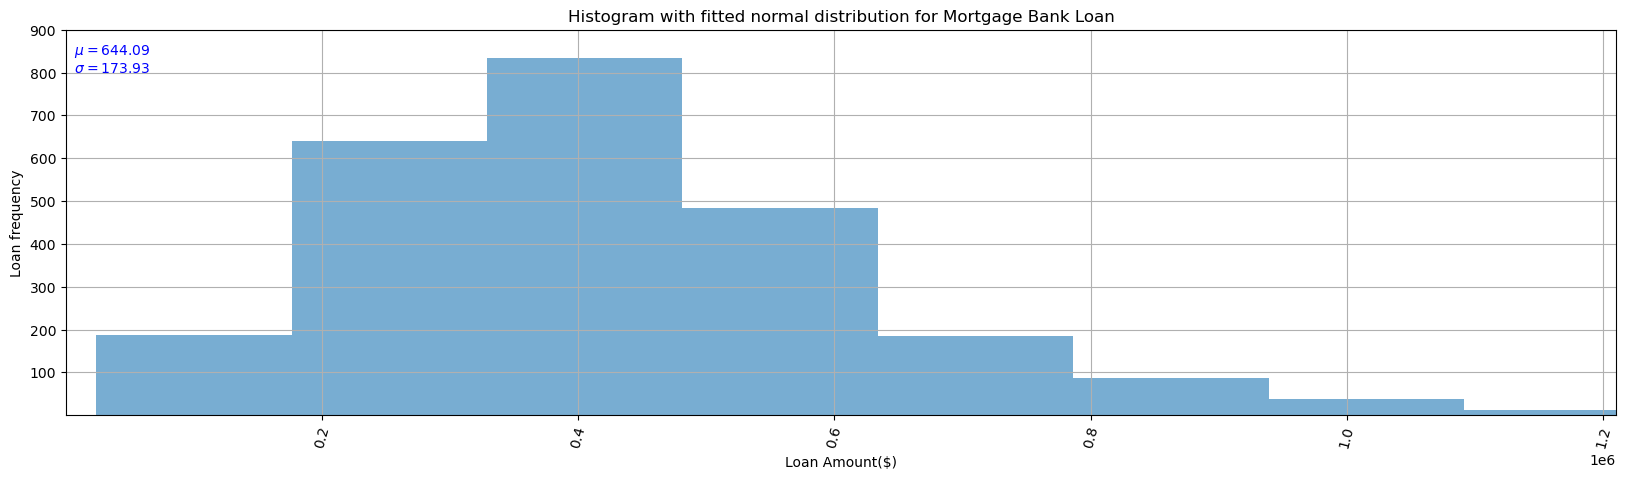

In [17]:
loan_patterns_plot = loan_patterns['Loan Amount'].hist(alpha=0.6, bins=40, grid=True,figsize=(20,5))

loan_patterns_plot = loan_patterns['Loan Amount'].apply(np.sqrt)

param = stats.norm.fit(loan_patterns_plot) 
x = np.linspace(0, 100000, 1250000)      # Linear spacing of 100 elements between 0 and 20.
pdf_fitted = stats.norm.pdf(x, *param)    # Use the fitted paramters to 
loan_patterns_plot.plot.hist(alpha=0.6, bins=40, grid=True, density=True, legend=None,figsize=(20,5))
# Fit a normal distribution to the data
# Plot the histogram again
# Plot some fancy text to show us what the paramters of the distribution are (mean and standard deviation)
plt.text(x=np.min(loan_patterns_plot), y=800, s=r"  $\mu=%0.2f$" % param[0] + "\n" 
         + r"  $\sigma=%0.2f$" % param[1], color='b')

# Plot a line of the fitted distribution over the top
# Standard plot stuff
plt.xticks(rotation=75)
plt.ylim((1,900))
plt.xlim((1,1210000))
plt.xlabel("Loan Amount($)")
plt.ylabel("Loan frequency")
plt.title("Histogram with fitted normal distribution for Mortgage Bank Loan")


In [20]:
print("mean : ", round(np.mean(loan_patterns_plot),2))
print("var  : ", round(np.var(loan_patterns_plot),2))
print("skew : ",round(skew(loan_patterns_plot),2))
print("kurt : ",round(kurtosis(loan_patterns_plot),2))

mean :  644.09
var  :  30252.44
skew :  1.62
kurt :  10.2


In [21]:
loan_patterns = data[['Loan Amount', 'Created Date']]
loan_patterns.head()

,Loan Amount,Created Date
0,506250.0,10/14/2014
1,206250.0,10/14/2014
2,648700.0,10/14/2014
3,412750.0,10/14/2014
4,522588.0,10/14/2014


In [22]:
mlo_num=data[['Loan Officer Name']]
mlo_num['date'] = pd.DatetimeIndex(data['Created Date'])
mlo_num = mlo_num.set_index('date')
monthly_mlo_num=mlo_num.resample('M').nunique()

monthly_loan_num=data[['LoanInMonth']]
monthly_loan_num.head()

/var/folders/zy/5q4wyzpn68dg7fc7ppn821sm0000gn/T/ipykernel_74218/216304721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlo_num['date'] = pd.DatetimeIndex(data['Created Date'])


,LoanInMonth
0,1
1,2
2,3
3,4
4,5


/var/folders/zy/5q4wyzpn68dg7fc7ppn821sm0000gn/T/ipykernel_74218/3508319273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_loan_num['date'] = pd.DatetimeIndex(data['Created Date'])


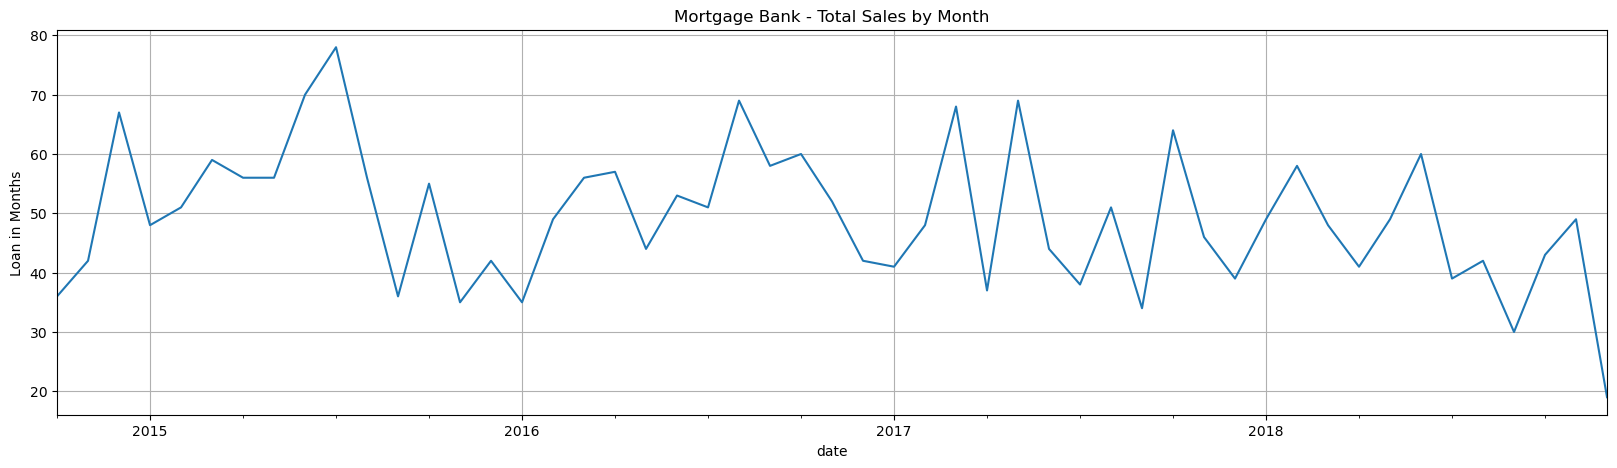

In [23]:
monthly_loan_num['date'] = pd.DatetimeIndex(data['Created Date'])
monthly_loan_num = monthly_loan_num.set_index('date')
monthly_loan_num_data=monthly_loan_num.resample('M').last().plot(title="Mortgage Bank - Total Sales by Month",
                                                                 legend=None,grid=True,figsize=(20,5))
plt.ylabel("Loan in Months")
plt.show()

### Summer seems to be high sales seasons for the Mortgage bank. Numbers of loans closed per months varies between 20 & 80.

/var/folders/zy/5q4wyzpn68dg7fc7ppn821sm0000gn/T/ipykernel_74218/663096051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_rev_data['date'] = pd.DatetimeIndex(data['Created Date'])


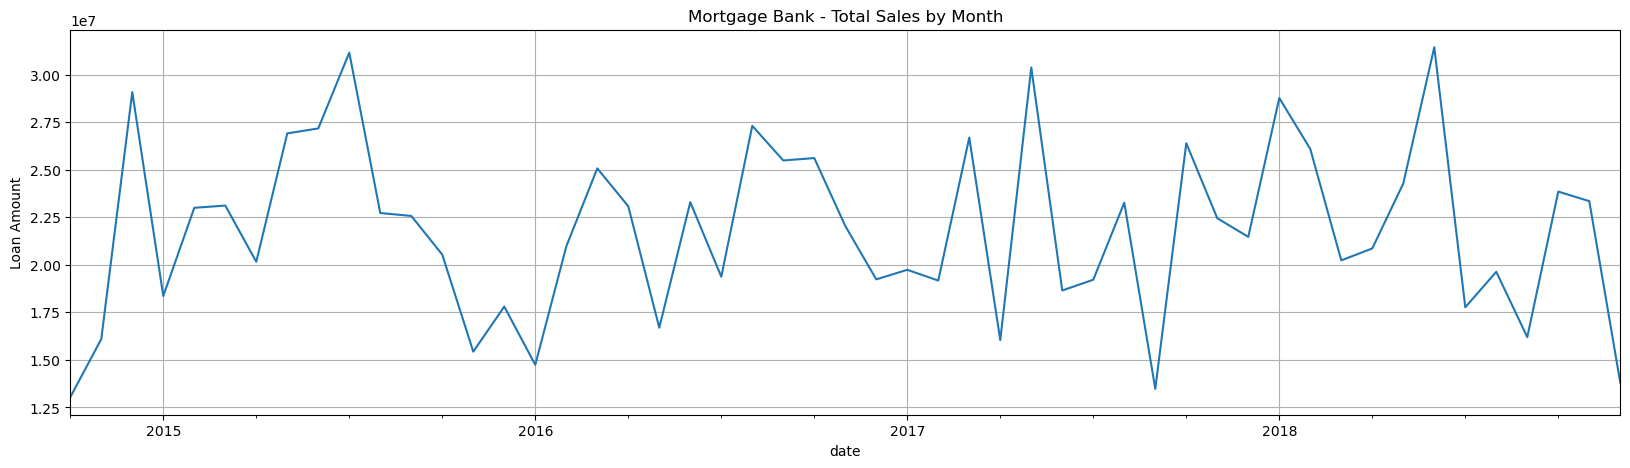

In [24]:
loan_rev_data=data[['Loan Amount']]
loan_rev_data['date'] = pd.DatetimeIndex(data['Created Date'])
loan_rev_data = loan_rev_data.set_index('date')
monthly_loan_rev_data=loan_rev_data.resample('M').sum().plot(title="Mortgage Bank - Total Sales by Month",
                                                             legend=None,grid=True,figsize=(20,5))
plt.ylabel("Loan Amount")
plt.show()

### Mortgage Bank Monthly Sales Since October 2014. Sales varies between 12M & 33M per months. 

# Are Interest Rates Autocorrelated?

When we look at daily changes in interest rates, the autocorrelation is close to zero. However, if we resample the data and look at annual changes, the autocorrelation is negative. This implies that while short term changes in interest rates may be uncorrelated, long term changes in interest rates are negatively autocorrelated. A daily move up or down in interest rates is unlikely to tell us anything about interest rates tomorrow, but a move in interest rates over a year can tell us something about where interest rates are going over the next year. And this makes some economic sense: over long horizons, when interest rates go up, the economy tends to slow down, which consequently causes interest rates to fall, and vice versa.

One of the really cool things that pandas allows us to do is resample the data. If we want to look at the data by monthly and anually. We can easily resample and sum it up. I’m using ‘M’ as the period for resampling which means the data should be resampled on a month boundary and 'A' for annual data'. Finally find the The autocorrelation of annual interest rate changes

In [25]:
US10Y['change_rates'] = US10Y.diff()
US10Y['change_rates'] = US10Y['change_rates'].dropna()
US10Y.describe()

,RATE,change_rates
count,1098.000000,1097.000000
mean,2.302286,0.000510
std,0.423337,0.041906
min,1.370000,-0.170000
25%,2.030000,-0.030000
50%,2.270000,0.000000
75%,2.507500,0.030000
max,3.240000,0.190000


#### Autocorrelation of daily interest rate changes 

In [26]:
autocorrelation_daily = US10Y['change_rates'].autocorr()
print("The autocorrelation of daily interest rate changes is %4.2f" %(autocorrelation_daily))

The autocorrelation of daily interest rate changes is -0.06


#### Autocorrelation of monthly interest rate changes

In [27]:
US10Y.index = pd.to_datetime(US10Y.index)
monthly_rate_data = US10Y['RATE'].resample(rule='M').last()

In [28]:
monthly_rate_data['diff_rates'] = monthly_rate_data.diff()
monthly_rate_data['diff_rates'] = monthly_rate_data['diff_rates'].dropna()
monthly_rate_data['diff_rates'][:5]

DATE
2014-11-30   -0.17
2014-12-31   -0.01
2015-01-31   -0.49
2015-02-28    0.32
2015-03-31   -0.06
Freq: M, Name: RATE, dtype: float64

In [29]:
autocorrelation_monthly = monthly_rate_data['diff_rates'].autocorr()
print("The autocorrelation of monthly interest rate changes is %4.2f" %(autocorrelation_monthly))

The autocorrelation of monthly interest rate changes is -0.02


#### Autocorrelation of yearly interest rate changes

In [30]:
US10Y.index = pd.to_datetime(US10Y.index)
annual_rate_data = US10Y['RATE'].resample(rule='A').last()

In [32]:
annual_rate_data['diff_rates'] = annual_rate_data.diff()
annual_rate_data['diff_rates'] = annual_rate_data['diff_rates'].dropna()
annual_rate_data['diff_rates']

DATE
2015-12-31    0.10
2016-12-31    0.18
2017-12-31   -0.05
2018-12-31    0.37
Freq: A-DEC, Name: RATE, dtype: float64

In [33]:
autocorrelation_annual = annual_rate_data['diff_rates'].autocorr()
print("The autocorrelation of annual interest rate changes is %4.2f" %(autocorrelation_annual))

The autocorrelation of annual interest rate changes is -0.97


#### Daily and monthly autocorrelation is small but the annual autocorrelation is large and negative

## Frequency Distribution of Loan Types

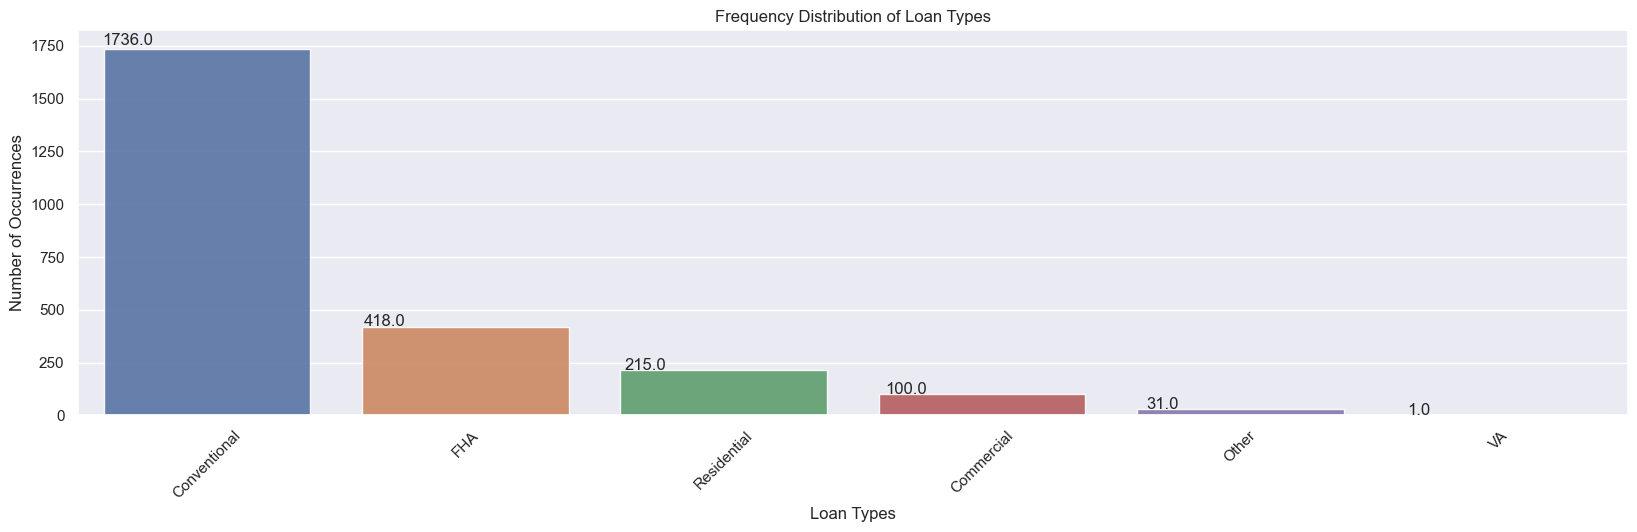

In [34]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
loan_type_count = data['Loan Type'].value_counts()
sns.set(style="darkgrid")
ax=sns.barplot(x=loan_type_count.index,y= loan_type_count.values, alpha=0.9)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.title('Frequency Distribution of Loan Types')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Types', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### Conventional loan type is top market for the Bank, second is FHA Loan Type

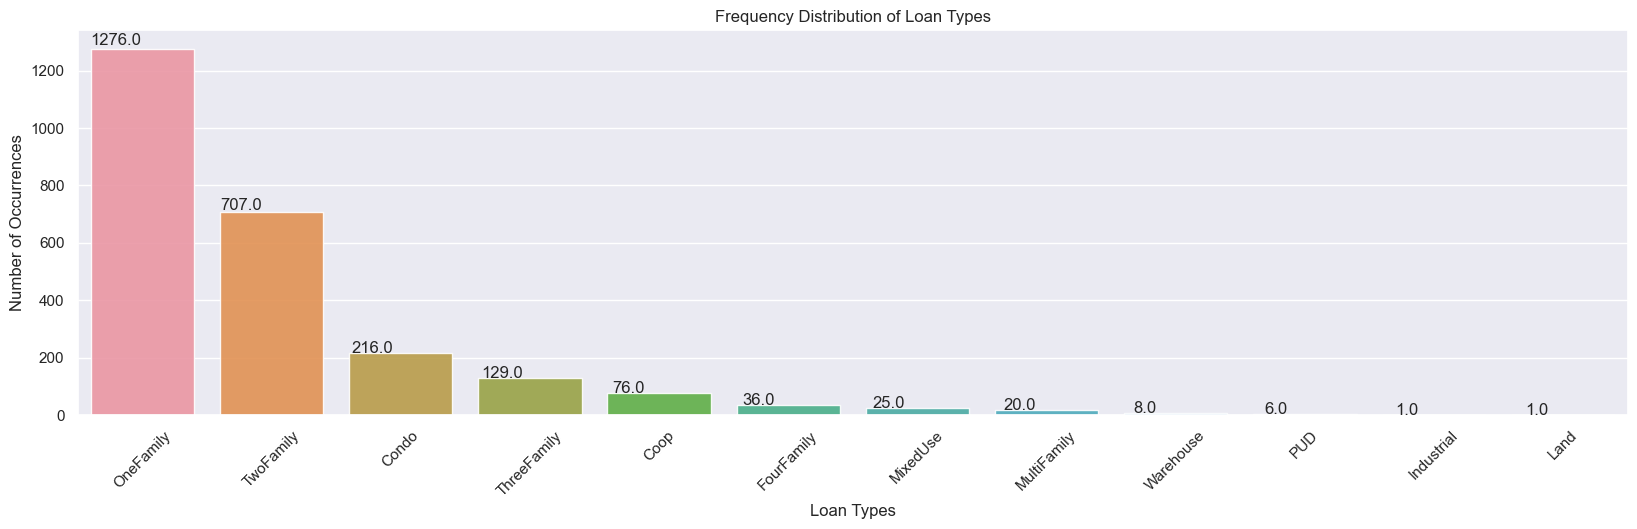

In [35]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
unit_type_count = data['Unit Type'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(20,5))
ax=sns.barplot(x=unit_type_count.index, y=unit_type_count.values, alpha=0.9)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.title('Frequency Distribution of Loan Types')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Types', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### One Family, Two Family and Condos are the top unit types for the Bank

## DATA EXPLORATION

Since our dataset can be grouped per day to create meaningful visualizations. The dataset contains data from October 2014 until December 2018. In order to get a feel of the amount of mortgage applications per day and the distribution of the mortgage applications, different visualizations can be made using Python. Two graphs have been created, which can be found in Figure 1 and Figure 2. Both of these graphs only contain the amount of mortgage applications on the weekdays. As there are almost no applications coming in on the weekends they have been excluded from the graphs. As can be seen from the graphs, there seems to be a seasonal pattern on a monthly level, but from these graphs it is not very clear. It also seems like there are some outliers, so these data points will have to be investigated to see if they will have to be included in our model, as there can be multiple underlying reasons for outliers in our dataset. It also seems there is an increase in mortgage applications during the last few months of each year. The amount of applications per day during these months is higher compared to the other months. This can have multiple explanations so this will have to be accounted for in the model.

In [41]:
loan_amount_data = data[data['Loan Amount'].isin(St)]
loan_amount_data.shape

(0, 24)

In [42]:
ct_loan_amount=sum(ct_data['Loan Amount'])
fl_loan_amount=sum(fl_data['Loan Amount'])
ny_loan_amount=sum(ny_data['Loan Amount'])
nj_loan_amount=sum(nj_data['Loan Amount'])
pa_loan_amount=sum(pa_data['Loan Amount'])

loan_amount_per_state = [ct_loan_amount, fl_loan_amount, nj_loan_amount, ny_loan_amount, pa_loan_amount]

print('====================================================')
print('=========    Total Sales by State     ==============')
print(' ')
print('Total Sales in Cunnecticut   : $', ct_loan_amount)
print('Total Sales in Florida       : $', fl_loan_amount)
print('Total Sales in New York      : $', ny_loan_amount)
print('Total Sales in New Jersey    : $', nj_loan_amount)
print('Total Sales in Pennsylvania  : $', pa_loan_amount)
print(' ')
print('====================================================')
print(' ')

=========    Total Sales by State     ==============
 
Total Sales in Cunnecticut   : $ 3604641.0
Total Sales in Florida       : $ 3371495.0
Total Sales in New York      : $ 868836552.2799997
Total Sales in New Jersey    : $ 236456261.05999997
Total Sales in Pennsylvania  : $ 600920.0
 
 


In [45]:
loan_types=data['Loan Type'].unique()
group_loan_types=data.groupby(data['Loan Type']).size()
print('Unique Loan Types:',loan_types)

Unique Loan Types: ['Residential' 'FHA' 'Commercial' 'Conventional' 'Other' 'VA']


In [46]:
print(' ')
print('====================================================')

print('Number of loan per Types : ', group_loan_types)

print(' ')
print('====================================================')
print(' ')

 
Number of loan per Types :  Loan Type
Commercial       100
Conventional    1736
FHA              418
Other             31
Residential      215
VA                 1
dtype: int64
 
 


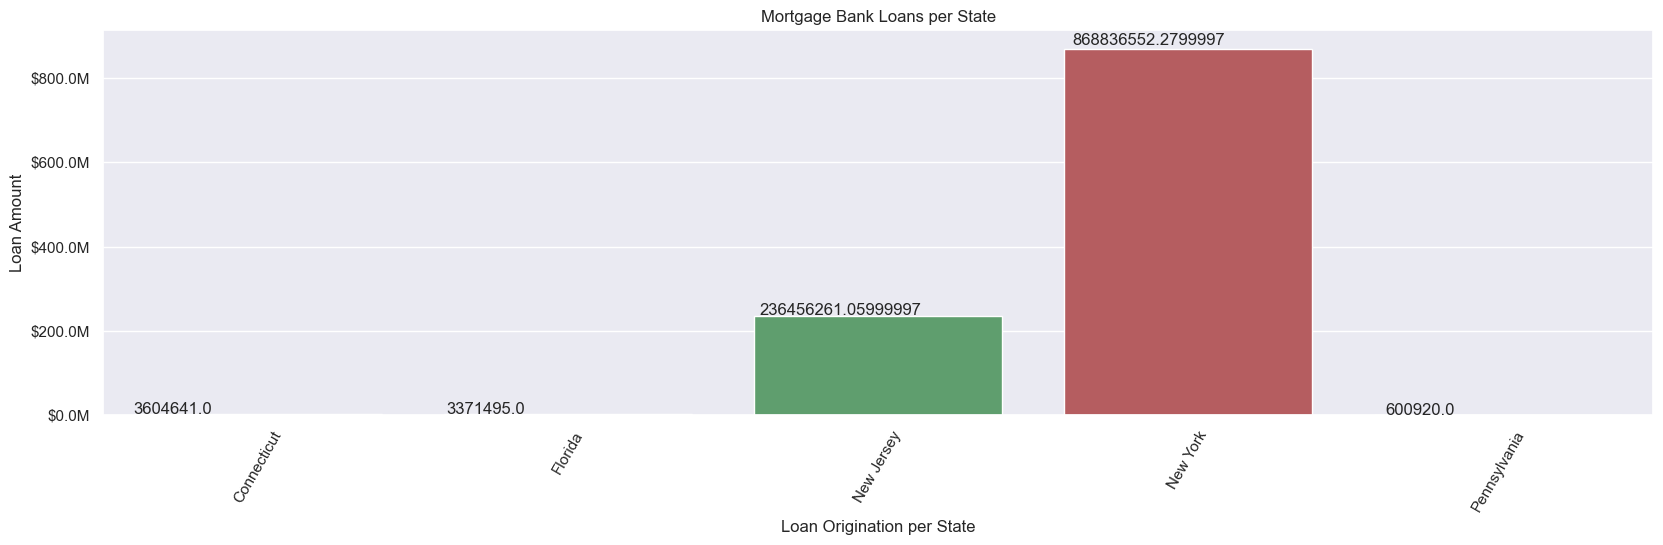

In [47]:
from matplotlib.ticker import FuncFormatter
x = np.arange(5)
money = [1.5e5, 2.5e6, 5.5e6, 1.0e7, 2.0e7, 3.0e7, 4.0e7, 5.0e7, 6.0e7]
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
fig, ax = plt.subplots(figsize=(20, 5))
ax.yaxis.set_major_formatter(formatter)
a=sns.barplot(x=St, y=loan_amount_per_state)
for p in a.patches:
    a.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.xticks(x, ('Connecticut', 'Florida', 'New Jersey', 'New York', 'Pennsylvania'))
plt.ylabel('Loan Amount')
plt.xlabel('Loan Origination per State')
plt.xticks(rotation=60)
plt.title('Mortgage Bank Loans per State')
plt.show()


### Even though Bank is Licensed for business in NY, NJ, CT, PA and FL, their strong mortgage market is in NY & NI

### Loan amount Distribution for CT State

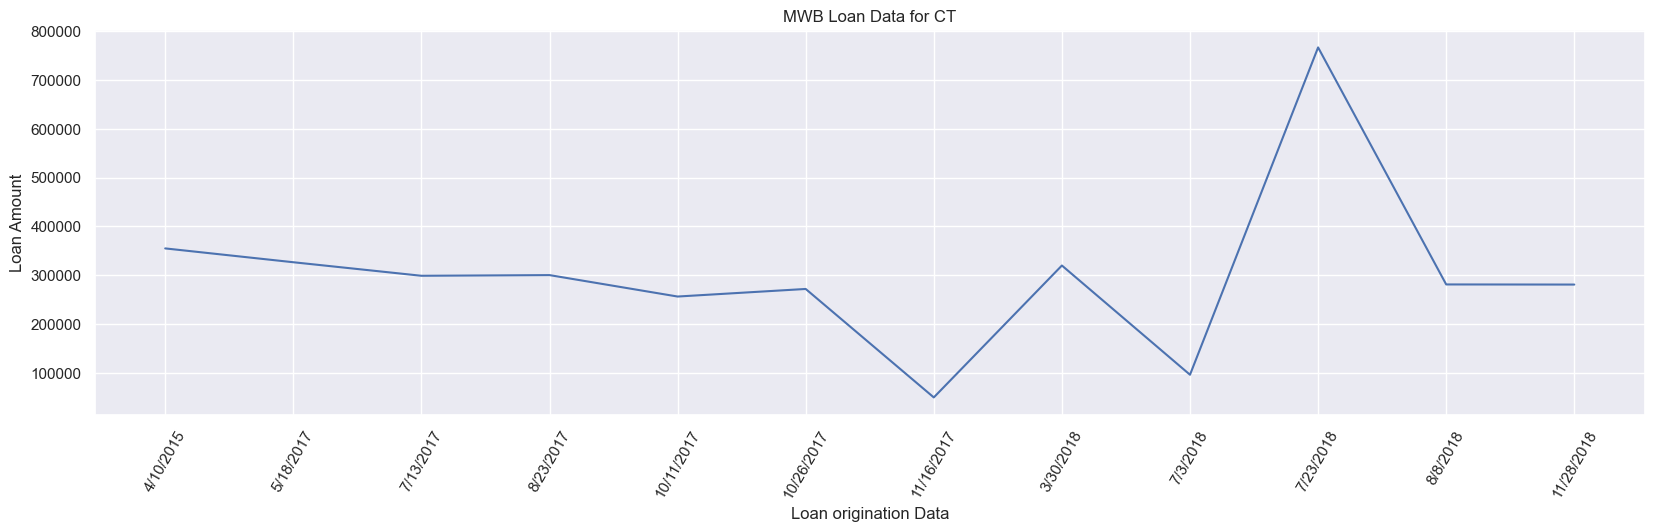

In [51]:
plt.figure(figsize=(20,5))
plt.xlabel('Loan origination Data')
plt.xticks(rotation=60)
plt.ylabel('Loan Amount')
plt.title('MWB Loan Data for CT')
plt.plot(ct_data['Created Date'], ct_data['Loan Amount'])
plt.show()

In [53]:
print('==============================')
print(' ')
total_unit_type = data.groupby(data['Unit Type']).size()
print('Loan originated in all States per unit types : \n', total_unit_type)

print('==============================')
print(' ')

 
Loan originated in all States per unit types : 
 Unit Type
Condo           216
Coop             76
FourFamily       36
Industrial        1
Land              1
MixedUse         25
MultiFamily      20
OneFamily      1276
PUD               6
ThreeFamily     129
TwoFamily       707
Warehouse         8
dtype: int64
 


In [54]:
print('==============================')
print(' ')

ct_data_unit_type = ct_data['Loan Amount'].groupby(ct_data['Unit Type']).size()

print('Loans originated in Connecticut per unit type:\n', ct_data_unit_type)

print('==============================')
print(' ')

 
Loans originated in Connecticut per unit type:
 Unit Type
OneFamily      9
ThreeFamily    3
Name: Loan Amount, dtype: int64
 


In [55]:
print('==============================')
print(' ')
fl_data_unit_type=fl_data['Loan Amount'].groupby(fl_data['Unit Type']).size()
print('Loan originated in Florida per unit types : \n', fl_data_unit_type)
print('==============================')
print(' ')

 
Loan originated in Florida per unit types : 
 Unit Type
Condo         1
OneFamily    11
Name: Loan Amount, dtype: int64
 


In [56]:
print('==============================')
print(' ')
nj_data_unit_type=nj_data['Loan Amount'].groupby(nj_data['Unit Type']).size()
print('Loan originated in New Jersey per unit types : \n', nj_data_unit_type)

print('==============================')
print(' ')

 
Loan originated in New Jersey per unit types : 
 Unit Type
Condo          140
FourFamily       2
OneFamily      448
PUD              1
ThreeFamily     10
TwoFamily       70
Name: Loan Amount, dtype: int64
 


In [57]:
print('==============================')
print(' ')
ny_data_unit_type=ny_data['Loan Amount'].groupby(ny_data['Unit Type']).size()
print('Loan originated in New York per unit types : \n', ny_data_unit_type)

print('==============================')
print(' ')

 
Loan originated in New York per unit types : 
 Unit Type
Condo           75
Coop            76
FourFamily      34
Industrial       1
Land             1
MixedUse        25
MultiFamily     20
OneFamily      805
PUD              5
ThreeFamily    116
TwoFamily      636
Warehouse        8
Name: Loan Amount, dtype: int64
 


In [58]:
print('==============================')
print(' ')
pa_data_unit_type=pa_data['Loan Amount'].groupby(data['Unit Type']).size()
print('Loan originated in Pennsylvania per unit types : \n', pa_data_unit_type)

print('==============================')
print(' ')

 
Loan originated in Pennsylvania per unit types : 
 Unit Type
OneFamily    2
TwoFamily    1
Name: Loan Amount, dtype: int64
 


## Loan data based on Unit Types (One Fami, Two Family etc) per State

In [63]:
lo_data = pd.read_csv('mwb2014.csv', header=0, index_col = 'Loan Officer Name', encoding='cp1252')


lo_df = lo_data[['Created Date', 'Loan Amount', 'Unit Type', 'Loan Type', 'City', 'Zip']]

lo_df.head()

,Created Date,Loan Amount,Unit Type,Loan Type,City,Zip
Loan Officer Name,,,,,,
73ch126 61g45d3s,10/14/2014,506250.0,TwoFamily,Residential,Edgewater,7020
73ch126 61g45d3s,10/14/2014,206250.0,Condo,Residential,EAST BRUNSWICK,8816
63s1 63,10/14/2014,648700.0,TwoFamily,Residential,WOODSIDE,11377
73ch126 61g45d3s,10/14/2014,412750.0,TwoFamily,Residential,Jackson Heights,11370
7189r22t Bh1s38,10/14/2014,522588.0,TwoFamily,FHA,Queens Village,10461


In [66]:
lo_df.describe()

,Loan Amount,Zip
count,2.501000e+03,2501.00000
mean,4.450999e+05,10465.72531
std,2.888040e+05,2864.01025
min,2.360000e+04,0.00000
25%,2.925000e+05,7830.00000
50%,4.000000e+05,11223.00000
75%,5.330000e+05,11412.00000
max,6.125000e+06,65488.00000


In [67]:
lo_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Loan Amount,2501.0,445099.907773,288803.958791,23600.0,292500.0,400000.0,533000.0,6125000.0
Zip,2501.0,10465.725310,2864.010250,0.0,7830.0,11223.0,11412.0,65488.0


In [68]:
print('=======================================================================')
print('**********************  Loan Statistics for Mortgage Bank ***********************')
print(' ')


from scipy.stats import scoreatpercentile
import numpy as np

q0 = scoreatpercentile(lo_df['Loan Amount'],10)
q1 = scoreatpercentile(lo_df['Loan Amount'],25)
q2 = scoreatpercentile(lo_df['Loan Amount'],55)
q3 = scoreatpercentile(lo_df['Loan Amount'],75)
q4 = scoreatpercentile(lo_df['Loan Amount'],90)


print('Average Loan Amount is               :  $', '%.2f' %lo_df['Loan Amount'].mean())
print('Median Loan Amount is                :  $', '%.2f' %lo_df['Loan Amount'].median())
print(' ')
print('Standard deviation of Loan Amount is :  $', '%.2f' %lo_df['Loan Amount'].std())
print(' ')
print('Minimum Loan Amount is               :  $', '%.2f' %lo_df['Loan Amount'].min())
print('Maximum Loan Amount is               :  $', '%.2f' %lo_df['Loan Amount'].max())
print(' ')
print('Total of Loan Amount is              :  $', '%.2f' %lo_df['Loan Amount'].sum())
print(' ')
print('10% of Loan Amount is below          :  $', '%.2f' %q0)
print('25% of Loan Amount is below          :  $', '%.2f' %q1)
print('50% of Loan Amount is below          :  $', '%.2f' %q2)
print('75% of Loan Amount is below          :  $', '%.2f' %q3)
print('90% of Loan Amount is below          :  $', '%.2f' %q4)
print(' ')
print('==========================================================================')


**********************  Loan Statistics for Mortgage Bank ***********************
 
Average Loan Amount is               :  $ 445099.91
Median Loan Amount is                :  $ 400000.00
 
Standard deviation of Loan Amount is :  $ 288803.96
 
Minimum Loan Amount is               :  $ 23600.00
Maximum Loan Amount is               :  $ 6125000.00
 
Total of Loan Amount is              :  $ 1113194869.34
 
10% of Loan Amount is below          :  $ 200000.00
25% of Loan Amount is below          :  $ 292500.00
50% of Loan Amount is below          :  $ 417000.00
75% of Loan Amount is below          :  $ 533000.00
90% of Loan Amount is below          :  $ 696500.00
 


## Feature Importance

The feature importance of each feature of our dataset by using the feature importance property of the model. Feature importance gives us a score for each feature of our data, the higher the score more important or relevant is the feature towards your output variable. Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

In [14]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

In [21]:
data = pd.read_csv('mwb2014.csv', index_col='Created Date', header=0, encoding='cp1252')
data_lc = data.copy()
data_lc['City'] = data_lc['City'].astype('category')
data_lc['Zip'] = data_lc['Zip'].astype('category')
data_lc['Loan Type'] = data_lc['Loan Type'].astype('category')
data_lc['Unit Type'] = data_lc['Unit Type'].astype('category')
data_lc['loan_purpose_code'] = data_lc['Loan Purpose'].astype('category')
data_lc['city_code'] = data_lc['City'].cat.codes
data_lc['zip_code'] = data_lc['Zip'].cat.codes
data_lc['loan_purpose_code'] = lb_make.fit_transform(data_lc['Loan Purpose'])
data_lc['loan_type_code'] = lb_make.fit_transform(data_lc['Loan Type'])
data_lc['unit_type_code'] = lb_make.fit_transform(data_lc['Unit Type'])
data_lc = pd.get_dummies(data_lc, columns=['Fix'], prefix = ['Fix'])
data_lc['Fix_True']
data_lc['Fix_False']
model_data1 = data_lc[['Loan Amount', 'city_code', 'zip_code', 
                       'loan_purpose_code', 'Qualification FICO', 'unit_type_code', 
                       'loan_type_code', 'Fix_True', 'CLTV', 'LoanInMonth']]
model_data1.columns

Index(['Loan Amount', 'city_code', 'zip_code', 'loan_purpose_code',
       'Qualification FICO', 'unit_type_code', 'loan_type_code', 'Fix_True',
       'CLTV', 'LoanInMonth'],
      dtype='object')

In [22]:
home_supply = pd.read_csv('MonHouseSupply.csv', header=0, index_col='DATE', encoding='cp1252')
home_supply.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 10/14/2014 to 12/1/2018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Home    51 non-null     float64
dtypes: float64(1)
memory usage: 816.0+ bytes


In [25]:
US10Y = pd.read_csv('US10Y.csv', header=0, index_col='DATE', encoding='cp1252')
US10Y.replace('.', -1, inplace=True)
US10Y= US10Y.replace(to_replace=[-1], value=[np.nan])
US10Y.tail()

,RATE
DATE,
12/21/2018,2.79
12/24/2018,2.74
12/25/2018,NaN
12/26/2018,2.81
12/27/2018,2.77


In [26]:
US10Y= US10Y.fillna(method='ffill')
US10Y= US10Y[['RATE']].astype('float64')
total_missing_rate=US10Y.isnull().sum()
total_missing_rate

RATE    0
dtype: int64

In [27]:
model_data2 = model_data1.join(US10Y)
total_missing=model_data2.isnull().sum()
model_data2= model_data2.fillna(method='ffill')
total_missing_model_data2=model_data2.isnull().sum()
total_missing_model_data2

Loan Amount           0
city_code             0
zip_code              0
loan_purpose_code     0
Qualification FICO    0
unit_type_code        0
loan_type_code        0
Fix_True              0
CLTV                  0
LoanInMonth           0
RATE                  0
dtype: int64

In [28]:
total_missing_home_supply=home_supply.isnull().sum()
model_data = model_data2.join(home_supply)
total_missing=model_data.isnull().sum()
model_data= model_data.fillna(method='ffill')
total_missing_home_supply=model_data.isnull().sum()
total_missing_home_supply

Loan Amount           0
city_code             0
zip_code              0
loan_purpose_code     0
Qualification FICO    0
unit_type_code        0
loan_type_code        0
Fix_True              0
CLTV                  0
LoanInMonth           0
RATE                  0
Home                  0
dtype: int64

In [31]:
model_data['CLTV']=model_data['CLTV'].astype('int64')
X = np.array(model_data.drop(['CLTV'], axis=1))
y = np.array(model_data['CLTV'])
Z = model_data.drop(['loan_purpose_code'], axis=1)

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
model.feature_importances_

array([0.13196387, 0.12210229, 0.12442108, 0.02679827, 0.13047689,
       0.04978341, 0.04639651, 0.01100845, 0.13245509, 0.13166853,
       0.0929256 ])

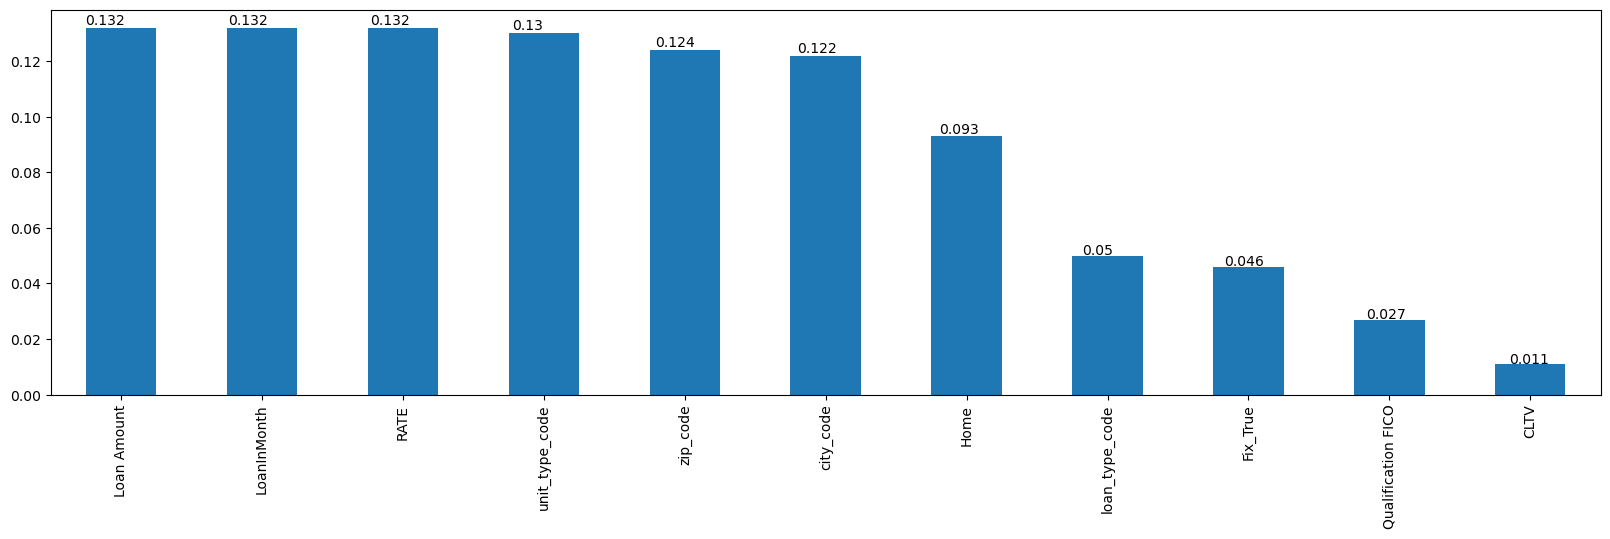

In [33]:
plt.figure(figsize=(20,5))
feat_importances = round((pd.Series(model.feature_importances_, index=Z.columns)),3)
ax=feat_importances.nlargest(11).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.show()

## Linear regression

Purpose of linear regression: Given a dataset containing predictor variables X and outcome/response variable Y, linear regression can be used to:

Build a predictive model to predict future values, using new data X where Y is unknown. Model the strength of the relationship between each independent variable X_i and Y Many times, only a subset of independent variables X_i will have a linear relationship with Y Need to figure out which X_i contributes most information to predict Y It is in many cases, the first pass prediction algorithm for continuous outcomes.

Linear Regression is a method to model the relationship between a set of independent variables X (also knowns as explanatory variables, features, predictors) and a dependent variable Y. This method assumes the relationship between each predictor X is linearly related to the dependent variable Y.

Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

In [34]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score

In [36]:
X = np.array(model_data.drop(['Loan Amount'],axis = 1))
y = np.array(model_data['Loan Amount'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print("size of the training feature set is",X_train.shape)
print("size of the test feature set is",X_test.shape)
print("size of the training Target set is",y_train.shape)
print("size of the test Target set is",y_test.shape)

size of the training feature set is (2000, 11)
size of the test feature set is (501, 11)
size of the training Target set is (2000,)
size of the test Target set is (501,)


In [38]:
from sklearn.linear_model import LinearRegression 
linear_reg= LinearRegression() 
linear_reg.fit(X_train,y_train)

LinearRegression()

In [39]:
predicted_train= linear_reg.predict(X_train)
predicted_test= linear_reg.predict(X_test)

In [40]:
from sklearn.metrics import mean_squared_error 

rmse_train=np.sqrt(mean_squared_error(y_train, predicted_train))
rmse_test=np.sqrt(mean_squared_error(y_test, predicted_test))

In [41]:
print('The train root mean squarred error is :', rmse_train)
print('The test root mean squarred error is  :', rmse_test)

The train root mean squarred error is : 234590.55098310494
The test root mean squarred error is  : 396271.3848332683


In [42]:
print('The Linear Regression coefficient parameters are :', linear_reg.coef_ )

The Linear Regression coefficient parameters are : [  -119.19589984    204.67590215  -8839.88659504    179.33675285
  16811.57127706 -35051.79265813 -68724.7366303     427.05554566
   -717.69409762  56789.37371078  16267.2703408 ]


In [43]:
print('The Linear Regression intercept value is :', linear_reg.intercept_)

The Linear Regression intercept value is : 76046.10985891963


### RMSE of the test data is closer to the training RMSE (and lower) if you have a well trained model. It will be higher if we have an overfitted model.

In [44]:
from sklearn import metrics
Rsquared=linear_reg.score(X_train,y_train) 

Rsquared
print('The R squared metric is :', Rsquared)

The R squared metric is : 0.12087027374771675


R^2 = 0.12

The R^2 in scikit learn is the coefficient of determination. It is 1 - residual sum of square / total sum of squares.

Since R^2 = 1 - RSS/TSS, the only case where RSS/TSS > 1 happens when our model is even worse than the worst model assumed (which is the absolute mean model).

here RSS = sum of squares of difference between actual values(yi) and predicted values(yi^) and TSS = sum of squares of difference between actual values (yi) and mean value (Before applying Regression). So you can imagine TSS representing the best(actual) model, and RSS being in between our best model and the worst absolute mean model in which case we'll get RSS/TSS < 1. If our model is even worse than the worst mean model then in that case RSS > TSS(Since difference between actual observation and mean value < difference predicted value and actual observation).

In [45]:
cv_score= cross_val_score(LinearRegression(),X,y,scoring='neg_mean_squared_error', cv=10) 
print('cv_score is :\n', cv_score)

cv_score is :
 [-1.04231965e+11 -2.87279883e+10 -6.70611569e+10 -6.83409350e+10
 -4.74302349e+10 -3.92732259e+10 -1.18199926e+11 -7.04316687e+10
 -3.51073072e+10 -1.80304701e+11]


In [46]:
print('cv_score is :', cv_score.mean())

cv_score is : -75910910860.8236


In [47]:
rmse_cv= np.sqrt(cv_score.mean() * -1)
print('The cross validation root mean squarred error is :', rmse_cv)

The cross validation root mean squarred error is : 275519.3475254026


With Linear regressor we are able to predict the model with RMSE: 
- train RMSE                                : 2.349923482270037 
- test RMSE                                 : 3.9655849638809144
- R squared                                 : 0.12 
- cross validation root mean squarred error : 2.75